In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CutMixRandom` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom
from semantic_segmentation_augmentations.regionmodifier import RegionModifier
from semantic_segmentation_augmentations.holesfilling import CutMixRandom

from vision_models_evaluation.core import evaluate
import albumentations as A
from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "CutMixRandomMod"
}

In order to know how does this technique work, we can show an example:

This technique removes all the information inside a selected region.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


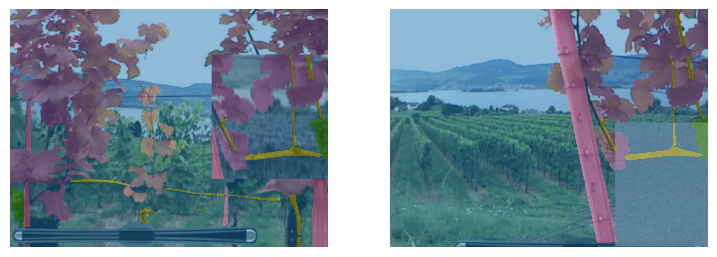

In [ ]:
cmr = CutMixRandom(holes_num = 1, modifier = RegionModifier(A.Compose([A.Blur(), A.GaussNoise()])), hole_maker = HoleMakerRandom((250, 250)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cmr) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cmr.x, cmr.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2]:
    for size in [(100, 100), (200, 200), (300, 300)]:
            cmr = CutMixRandom(holes_num = 1, modifier = RegionModifier(A.Compose([A.Blur(), A.GaussNoise()])), hole_maker = HoleMakerRandom((250, 250)))
            learner_hparams["cbs"] = [esc, cmr]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                str(holes_num) + str(size): r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.934896,0.632041,0.316610,00:20
1,0.712857,0.734568,0.389014,00:19
2,0.668722,0.477021,0.455261,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.453470,0.385075,0.520637,00:19
1,0.421605,0.352202,0.561947,00:19
2,0.379601,0.328888,0.691638,00:19
3,0.368425,0.405206,0.557629,00:19
4,0.364358,0.328696,0.728024,00:20
5,0.361227,0.301687,0.719833,00:20
6,0.348474,0.318450,0.760007,00:19
7,0.336437,0.289578,0.772738,00:19
8,0.332224,0.314383,0.780731,00:19
9,0.313501,0.356183,0.772286,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.17741963267326355  /  DiceMulti: 0.8638510105433947  
Saving best model because DiceMulti 0.8639 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.110587,0.738727,0.315980,00:20
1,0.793322,0.509813,0.347697,00:20
2,0.685488,0.616569,0.345324,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.507885,0.394142,0.422801,00:20
1,0.454645,0.356873,0.423614,00:20
2,0.416867,0.367538,0.650648,00:20
3,0.391514,0.312807,0.740902,00:20
4,0.372778,0.330291,0.737309,00:20
5,0.359084,0.310491,0.714436,00:20
6,0.363926,0.397429,0.603302,00:20
7,0.358663,0.283206,0.740888,00:20
8,0.338870,0.270171,0.796396,00:20
9,0.320337,0.317138,0.783467,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.18716156482696533  /  DiceMulti: 0.8709476272966015  
Saving best model because DiceMulti 0.8709 >= 0.8639.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.001935,0.542097,0.348003,00:19
1,0.754467,0.499954,0.344200,00:20
2,0.729051,0.546305,0.336214,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.492731,0.417055,0.406687,00:20
1,0.448794,0.374684,0.516999,00:20
2,0.408253,0.364245,0.563246,00:20
3,0.384226,0.311933,0.699815,00:20
4,0.368496,0.308445,0.747750,00:20
5,0.348544,0.294613,0.773786,00:20
6,0.331007,0.281361,0.770988,00:20
7,0.322891,0.284069,0.778643,00:20
8,0.315590,0.355171,0.745815,00:20
9,0.312816,0.277450,0.800376,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1762753427028656  /  DiceMulti: 0.8646641397228649  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.909471,0.509107,0.349030,00:20
1,0.722622,0.403723,0.377404,00:19
2,0.761918,0.707291,0.361517,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.529138,0.350545,0.434409,00:20
1,0.474752,0.314213,0.496272,00:20
2,0.430205,0.301223,0.584311,00:20
3,0.404420,0.293869,0.761374,00:20
4,0.391459,0.288482,0.663895,00:20
5,0.379589,0.309142,0.689958,00:20
6,0.366193,0.345113,0.705039,00:20
7,0.356967,0.235291,0.792252,00:20
8,0.344621,0.263813,0.794018,00:20
9,0.331311,0.231783,0.810270,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.18664106726646423  /  DiceMulti: 0.8613073975278084  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.965935,0.670706,0.330794,00:19
1,0.705860,0.476170,0.377749,00:20
2,0.577112,0.577695,0.463792,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.417467,0.352460,0.556764,00:20
1,0.397093,0.325307,0.714972,00:20
2,0.370969,0.317617,0.699771,00:20
3,0.366505,0.310122,0.769429,00:20
4,0.349487,0.271639,0.794287,00:20
5,0.343108,0.279014,0.777412,00:20
6,0.330351,0.290992,0.774472,00:20
7,0.315466,0.269921,0.809571,00:20
8,0.308347,0.311545,0.793829,00:20
9,0.303237,0.260434,0.810886,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.22842645645141602  /  DiceMulti: 0.81440689271123  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.981401,0.562470,0.328887,00:20
1,0.671301,0.529689,0.387981,00:20
2,0.531313,0.552907,0.454789,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.360149,0.442659,0.632593,00:20
1,0.327241,0.398339,0.661497,00:20
2,0.311350,0.419785,0.704868,00:20
3,0.294269,0.373389,0.690585,00:20
4,0.296039,0.446652,0.706377,00:20
5,0.297093,0.362334,0.723451,00:20
6,0.305493,0.460135,0.676286,00:21
7,0.298007,0.487537,0.688074,00:20
8,0.289470,0.379919,0.745496,00:21
9,0.289582,0.481322,0.711158,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.22417373955249786  /  DiceMulti: 0.8416195175515799  
Saving best model because DiceMulti 0.8416 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.060103,0.710812,0.305052,00:19
1,0.735047,0.647157,0.296241,00:20
2,0.989066,0.951612,0.212993,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.596281,0.504963,0.404881,00:20
1,0.507065,0.405989,0.419578,00:20
2,0.465538,0.402874,0.462473,00:20
3,0.422412,0.318908,0.654379,00:20
4,0.393141,0.331025,0.609851,00:20
5,0.380852,0.308994,0.709316,00:20
6,0.357458,0.293437,0.745514,00:20
7,0.348782,0.272741,0.783821,00:20
8,0.341732,0.289524,0.786504,00:20
9,0.328750,0.274342,0.773049,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.21228866279125214  /  DiceMulti: 0.8382726205934921  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.189943,0.669971,0.316938,00:20
1,0.813267,0.514675,0.340510,00:20
2,0.727306,1.012325,0.160645,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.517483,0.463377,0.365470,00:20
1,0.454446,0.359988,0.461352,00:20
2,0.424767,0.348700,0.560745,00:20
3,0.386762,0.321885,0.708735,00:20
4,0.377379,0.300101,0.778113,00:21
5,0.350139,0.293310,0.779247,00:21
6,0.341964,0.318372,0.765567,00:20
7,0.341731,0.300121,0.735091,00:20
8,0.325800,0.299588,0.764154,00:21
9,0.321822,0.289099,0.784674,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.15662342309951782  /  DiceMulti: 0.8804250297330404  
Saving best model because DiceMulti 0.8804 >= 0.8416.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.910376,0.560176,0.354968,00:20
1,0.707415,0.529609,0.356155,00:20
2,0.629607,0.477510,0.347324,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.447659,0.335992,0.650924,00:20
1,0.423618,0.289790,0.571657,00:20
2,0.403255,0.283539,0.674059,00:20
3,0.371022,0.254058,0.763042,00:20
4,0.356557,0.343921,0.678719,00:20
5,0.346889,0.242382,0.780415,00:20
6,0.345975,0.293769,0.672979,00:20
7,0.330850,0.237377,0.762110,00:20
8,0.326505,0.256406,0.806693,00:20
9,0.317407,0.219005,0.828239,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.19245004653930664  /  DiceMulti: 0.8583903723587349  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.981390,0.922443,0.304609,00:20
1,0.715984,0.441124,0.355142,00:20
2,0.612936,0.579136,0.394772,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.455472,0.408504,0.418958,00:20
1,0.414494,0.359957,0.453073,00:20
2,0.384655,0.293149,0.738205,00:20
3,0.367200,0.311209,0.747922,00:20
4,0.351707,0.276749,0.723546,00:20
5,0.340955,0.292580,0.800433,00:20
6,0.337354,0.280598,0.789003,00:20
7,0.317637,0.266021,0.798566,00:20
8,0.305494,0.269609,0.793208,00:20
9,0.297523,0.300204,0.802065,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.24131548404693604  /  DiceMulti: 0.8134943568473727  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.103519,0.652048,0.323071,00:20
1,0.726435,0.554635,0.332563,00:20
2,0.762736,0.814358,0.311081,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.482524,0.528019,0.376127,00:20
1,0.438110,0.447578,0.486623,00:20
2,0.398225,0.441613,0.558565,00:20
3,0.386262,0.451336,0.637628,00:21
4,0.359134,0.415715,0.652637,00:20
5,0.333134,0.396642,0.709951,00:20
6,0.324021,0.417307,0.705239,00:20
7,0.307595,0.388173,0.717205,00:20
8,0.299628,0.429736,0.581848,00:20
9,0.292435,0.423186,0.734724,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2139948159456253  /  DiceMulti: 0.8089662557721946  
Saving best model because DiceMulti 0.809 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.960789,0.998727,0.221174,00:19
1,0.703356,0.636352,0.367450,00:20
2,0.597500,0.446682,0.483411,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.428636,0.395308,0.566015,00:20
1,0.394220,0.338709,0.741039,00:20
2,0.368626,0.299381,0.755505,00:20
3,0.350643,0.302220,0.757575,00:20
4,0.334757,0.257881,0.790199,00:20
5,0.326354,0.279406,0.794307,00:20
6,0.346853,0.313544,0.765492,00:20
7,0.324454,0.253353,0.815352,00:20
8,0.323528,0.334927,0.783306,00:20
9,0.308584,0.251907,0.805577,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.23764900863170624  /  DiceMulti: 0.8089669281359251  
Saving best model because DiceMulti 0.809 >= 0.809.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.158724,0.682862,0.326663,00:20
1,0.825370,0.556460,0.330086,00:20
2,1.485216,0.930949,0.135718,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.580404,0.425976,0.353780,00:20
1,0.515284,0.387221,0.419279,00:21
2,0.479220,0.402787,0.434464,00:20
3,0.442819,0.344290,0.586420,00:20
4,0.408018,0.362407,0.606871,00:21
5,0.375797,0.317367,0.720526,00:20
6,0.362084,0.297593,0.742482,00:20
7,0.346717,0.325650,0.722621,00:20
8,0.343890,0.340206,0.719366,00:20
9,0.331508,0.276186,0.795792,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.16077890992164612  /  DiceMulti: 0.8792322524183522  
Saving best model because DiceMulti 0.8792 >= 0.809.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.996660,0.658041,0.334341,00:20
1,0.743755,0.477345,0.351691,00:20
2,0.690721,0.488331,0.348249,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.465095,0.292986,0.605879,00:20
1,0.424709,0.268405,0.723130,00:20
2,0.386682,0.264826,0.724557,00:21
3,0.362814,0.252728,0.763798,00:20
4,0.352393,0.255391,0.784410,00:21
5,0.349915,0.268776,0.793598,00:20
6,0.340420,0.226009,0.810487,00:20
7,0.339439,0.243463,0.807731,00:20
8,0.328176,0.305478,0.780170,00:20
9,0.318989,0.237905,0.781944,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2265271246433258  /  DiceMulti: 0.852687044747638  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.143432,0.791120,0.298577,00:20
1,0.848049,0.502728,0.350745,00:20
2,0.705562,0.715149,0.319248,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.478695,0.471746,0.395917,00:21
1,0.429772,0.352562,0.679429,00:20
2,0.398936,0.338383,0.741418,00:20
3,0.380000,0.325869,0.729300,00:20
4,0.356994,0.266949,0.772049,00:21
5,0.350347,0.285041,0.768452,00:21
6,0.339058,0.293756,0.733461,00:20
7,0.326716,0.312167,0.689823,00:20
8,0.320259,0.273932,0.793336,00:20
9,0.305859,0.277106,0.783103,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.28740283846855164  /  DiceMulti: 0.7570034829683555  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.093424,0.725929,0.298298,00:20
1,0.754941,0.558205,0.396789,00:20
2,0.627026,0.567871,0.338774,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.425806,0.444946,0.522201,00:20
1,0.409167,0.417538,0.574503,00:20
2,0.368670,0.393469,0.672789,00:20
3,0.340284,0.410668,0.638556,00:20
4,0.326969,0.416464,0.651800,00:21
5,0.321862,0.504191,0.682015,00:20
6,0.309596,0.420633,0.649563,00:20
7,0.294887,0.386353,0.710180,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.22544167935848236  /  DiceMulti: 0.809527136533506  
Saving best model because DiceMulti 0.8095 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.950411,0.636610,0.344114,00:20
1,0.738047,0.658095,0.307357,00:20
2,0.667162,0.446634,0.350943,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.464716,0.373045,0.493996,00:20
1,0.448231,0.361716,0.609626,00:20
2,0.413534,0.318852,0.662168,00:20
3,0.377107,0.299092,0.783764,00:20
4,0.368265,0.314848,0.621109,00:20
5,0.356076,0.321088,0.754963,00:20
6,0.356978,0.280059,0.806675,00:21
7,0.346311,0.304247,0.780485,00:20
8,0.344163,0.268806,0.798126,00:20
9,0.327919,0.250542,0.812492,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.23558299243450165  /  DiceMulti: 0.8211445850864401  
Saving best model because DiceMulti 0.8211 >= 0.8095.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.836610,0.672313,0.316618,00:20
1,0.705629,0.533557,0.339472,00:20
2,0.613669,0.878818,0.336311,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.493272,0.370763,0.555594,00:20
1,0.424243,0.355691,0.627674,00:20
2,0.391861,0.318136,0.642355,00:20
3,0.363511,0.352548,0.702263,00:20
4,0.345089,0.337833,0.698153,00:20
5,0.332446,0.287600,0.772045,00:20
6,0.323120,0.278730,0.770351,00:20
7,0.313061,0.286434,0.804409,00:20
8,0.310717,0.264777,0.810960,00:20
9,0.294346,0.292655,0.797790,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.17975389957427979  /  DiceMulti: 0.8623524108934795  
Saving best model because DiceMulti 0.8624 >= 0.8211.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.998261,0.784169,0.333865,00:20
1,0.714271,0.457543,0.425430,00:20
2,0.646558,0.388629,0.357509,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.452885,0.299790,0.613301,00:20
1,0.404781,0.306324,0.620110,00:20
2,0.378794,0.258592,0.749253,00:20
3,0.360368,0.252193,0.739354,00:21
4,0.353627,0.235554,0.812694,00:20
5,0.362487,0.257157,0.791397,00:20
6,0.370072,0.244638,0.777961,00:20
7,0.347710,0.253266,0.700856,00:20
8,0.339347,0.221127,0.826450,00:21
9,0.350339,0.244116,0.818305,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.2026936262845993  /  DiceMulti: 0.8416750538852558  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.053743,0.800781,0.286627,00:20
1,0.725894,0.493199,0.369681,00:20
2,0.624326,0.513089,0.371716,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.452648,0.376800,0.557776,00:21
1,0.439197,0.344223,0.592976,00:20
2,0.399793,0.384724,0.575667,00:20
3,0.379778,0.295745,0.770036,00:20
4,0.363199,0.289234,0.772291,00:21
5,0.355773,0.301022,0.779704,00:20
6,0.350780,0.279697,0.753138,00:20
7,0.337092,0.284740,0.760920,00:20
8,0.332224,0.294994,0.750057,00:20
9,0.313838,0.273942,0.800217,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2757739722728729  /  DiceMulti: 0.7692746770343541  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.885299,0.782844,0.298009,00:20
1,0.668061,0.528541,0.333652,00:20
2,0.931896,1.474847,0.173943,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.838762,0.606297,0.322631,00:20
1,0.621642,0.501525,0.338482,00:20
2,0.513329,0.474287,0.400678,00:20
3,0.440460,0.411490,0.631517,00:20
4,0.388306,0.414166,0.660136,00:20
5,0.370676,0.393159,0.683118,00:20
6,0.340114,0.443477,0.708264,00:20
7,0.321422,0.398302,0.710297,00:20
8,0.314689,0.400921,0.677043,00:20
9,0.298236,0.477728,0.714483,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.21572408080101013  /  DiceMulti: 0.8259931236636637  
Saving best model because DiceMulti 0.826 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.889651,0.582029,0.341083,00:20
1,0.714890,0.703308,0.318727,00:20
2,1.868969,1.206918,0.204787,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.707584,0.460997,0.353148,00:21
1,0.592198,0.434919,0.352237,00:20
2,0.505905,0.411195,0.423916,00:20
3,0.470277,0.402727,0.558487,00:20
4,0.424805,0.348488,0.610017,00:20
5,0.391415,0.354611,0.712484,00:20
6,0.406042,0.329841,0.689190,00:20
7,0.376497,0.315863,0.740961,00:20
8,0.360817,0.281817,0.785033,00:20
9,0.366609,0.328158,0.607087,00:21


No improvement since epoch 23: early stopping


Test results for the model.   validation: 0.18103961646556854  /  DiceMulti: 0.8566230771818523  
Saving best model because DiceMulti 0.8566 >= 0.826.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.008885,0.670686,0.298109,00:20
1,0.696817,0.416690,0.483167,00:20
2,0.772731,0.845385,0.236218,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.532927,0.564489,0.388078,00:20
1,0.464896,0.364715,0.499500,00:20
2,0.421642,0.337207,0.603880,00:20
3,0.394371,0.368814,0.613092,00:21
4,0.366741,0.304118,0.727657,00:20
5,0.360617,0.305624,0.741316,00:20
6,0.356313,0.430317,0.652392,00:20
7,0.353111,0.362521,0.779392,00:21
8,0.342162,0.314450,0.748970,00:21
9,0.330516,0.267990,0.801176,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.19115307927131653  /  DiceMulti: 0.8448609884644999  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.907675,0.623632,0.354163,00:20
1,0.645279,0.384726,0.373637,00:20
2,1.288129,14.234520,0.117729,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,3.225288,0.566942,0.352841,00:20
1,1.491071,0.428262,0.353518,00:20
2,0.932253,0.373424,0.391142,00:20
3,0.680210,0.308170,0.550167,00:21
4,0.548223,0.329787,0.588217,00:20
5,0.479595,0.285653,0.673281,00:20
6,0.450101,0.288131,0.535496,00:20
7,0.419006,0.248767,0.745134,00:21
8,0.384419,0.228796,0.798695,00:20
9,0.354680,0.254534,0.746586,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.25025197863578796  /  DiceMulti: 0.8044578611728607  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.926865,0.672249,0.330758,00:20
1,0.700643,0.555672,0.334147,00:20
2,0.642355,0.486514,0.350152,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.435009,0.403925,0.470381,00:21
1,0.406252,0.337726,0.606645,00:20
2,0.379497,0.334609,0.724445,00:21
3,0.351474,0.304087,0.734786,00:20
4,0.337790,0.270579,0.796218,00:21
5,0.335447,0.310907,0.745222,00:21
6,0.340922,0.343640,0.715707,00:20
7,0.346772,0.266608,0.807030,00:20
8,0.325354,0.247577,0.817925,00:20
9,0.317125,0.251502,0.819707,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.25809139013290405  /  DiceMulti: 0.7867568559975923  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.037017,0.738867,0.290313,00:20
1,0.735642,0.559531,0.364741,00:20
2,0.605790,0.609116,0.335732,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.396576,0.426693,0.555902,00:20
1,0.364178,0.417317,0.652804,00:20
2,0.335345,0.484790,0.683811,00:20
3,0.335781,0.412666,0.690608,00:20
4,0.322441,0.367458,0.722224,00:20
5,0.304265,0.459201,0.643943,00:20
6,0.309832,0.394426,0.722518,00:21
7,0.302178,0.386425,0.698613,00:21
8,0.295060,0.475058,0.696386,00:21
9,0.284683,0.436323,0.736246,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2073475420475006  /  DiceMulti: 0.8437815727191378  
Saving best model because DiceMulti 0.8438 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.133622,0.699700,0.322303,00:19
1,0.823239,0.578469,0.364632,00:20
2,0.758704,0.527991,0.336686,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.539172,0.493899,0.396201,00:20
1,0.478987,0.371831,0.524232,00:21
2,0.436987,0.330265,0.580069,00:20
3,0.410789,0.321860,0.679675,00:20
4,0.383050,0.276499,0.778515,00:20
5,0.358591,0.292439,0.783188,00:20
6,0.338659,0.340246,0.750061,00:20
7,0.341283,0.320720,0.803068,00:20
8,0.333193,0.261906,0.815149,00:20
9,0.319919,0.285937,0.792115,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.16684681177139282  /  DiceMulti: 0.8710586327239657  
Saving best model because DiceMulti 0.8711 >= 0.8438.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.888554,0.599180,0.334718,00:20
1,0.683106,0.479345,0.369409,00:20
2,0.812388,0.989380,0.257169,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.589872,0.487804,0.348082,00:21
1,0.503308,0.480822,0.418471,00:20
2,0.496594,0.461840,0.420767,00:20
3,0.442838,0.351658,0.620324,00:20
4,0.432202,0.364866,0.610944,00:20
5,0.394554,0.308241,0.718566,00:20
6,0.370844,0.334817,0.632185,00:20
7,0.355625,0.311099,0.740819,00:20
8,0.349087,0.308156,0.757384,00:20
9,0.343851,0.732191,0.576952,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.1793232262134552  /  DiceMulti: 0.8325889416679655  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.999692,0.735255,0.318824,00:20
1,0.709621,0.490369,0.345770,00:20
2,0.601903,0.319841,0.479399,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.420870,0.274909,0.659762,00:20
1,0.395760,0.256313,0.742405,00:20
2,0.365349,0.249415,0.697662,00:21
3,0.356568,0.244841,0.794305,00:21
4,0.346553,0.222262,0.811177,00:20
5,0.338670,0.243892,0.796282,00:21
6,0.332380,0.260374,0.816443,00:20
7,0.349015,0.253108,0.820697,00:21
8,0.341331,0.238797,0.797513,00:20
9,0.326101,0.260581,0.802628,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.24711547791957855  /  DiceMulti: 0.8193018515985567  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.943259,0.521912,0.352073,00:20
1,0.706080,0.627965,0.320360,00:20
2,0.704343,1.102171,0.320680,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.495356,0.506557,0.378743,00:20
1,0.448644,0.383649,0.561210,00:20
2,0.411359,0.324846,0.655237,00:20
3,0.383794,0.355774,0.658016,00:20
4,0.361869,0.346511,0.687877,00:20
5,0.355583,0.275621,0.775605,00:20
6,0.337215,0.295687,0.759443,00:20
7,0.315484,0.250748,0.816218,00:20
8,0.312061,0.342890,0.761122,00:21
9,0.312280,0.320240,0.799853,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2449638843536377  /  DiceMulti: 0.7985683952715092  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(100, 100)","1(200, 200)","1(300, 300)","2(100, 100)","2(200, 200)","2(300, 300)"
0,0.863851,0.841620,0.808966,0.809527,0.825993,0.843782
1,0.870948,0.838273,0.808967,0.821145,0.856623,0.871059
2,0.864664,0.880425,0.879232,0.862352,0.844861,0.832589
3,0.861307,0.858390,0.852687,0.841675,0.804458,0.819302
4,0.814407,0.813494,0.757003,0.769275,0.786757,0.798568


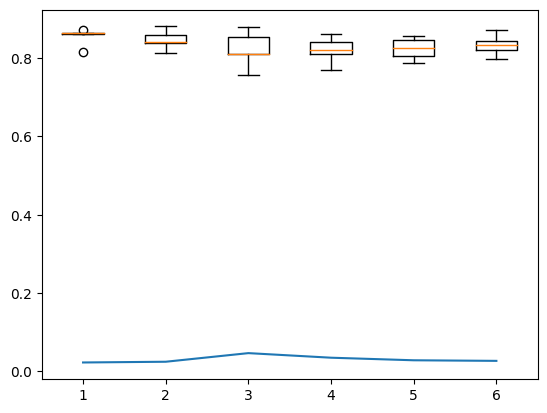

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(100, 100)",0.855035,0.022987
"1(200, 200)",0.846440,0.024865
"1(300, 300)",0.821371,0.046850
"2(100, 100)",0.820795,0.035158
"2(200, 200)",0.823738,0.028601
"2(300, 300)",0.833060,0.027102


We save the results in order to plot them together.

In [ ]:
folds = [["CMRmod" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("CutMixRandomMod")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


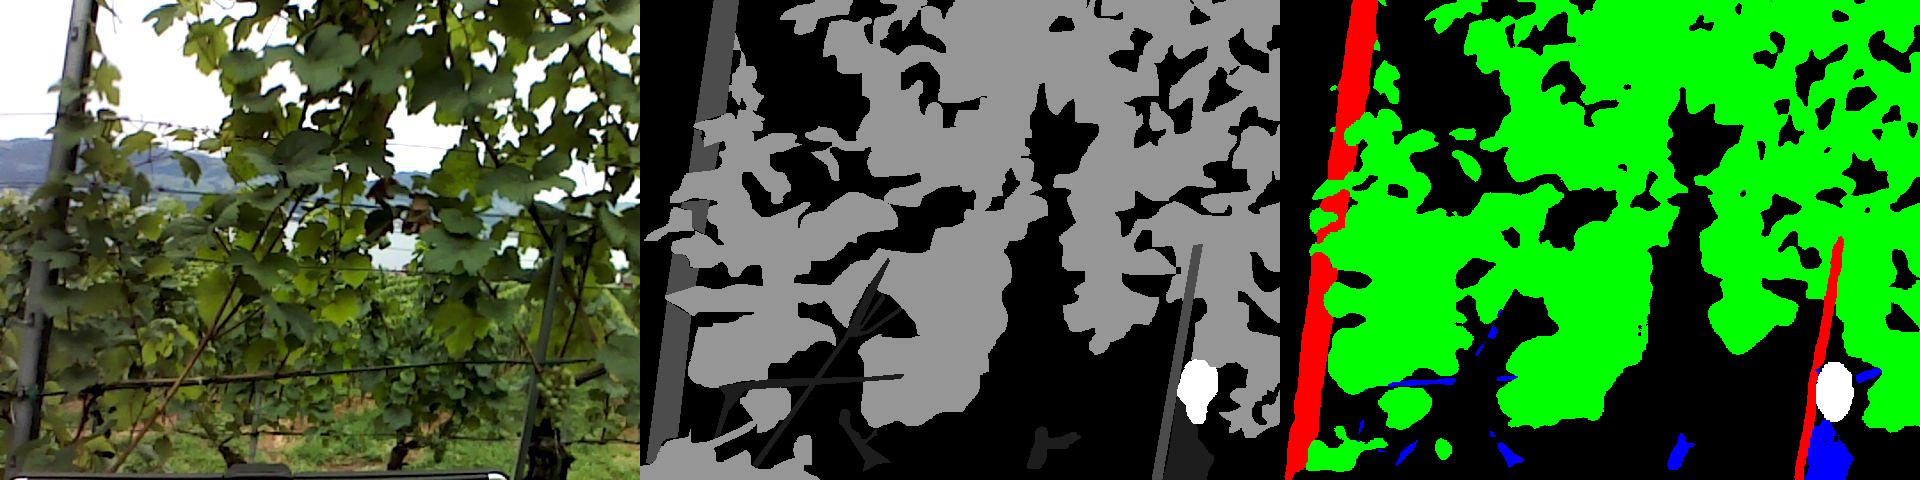

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

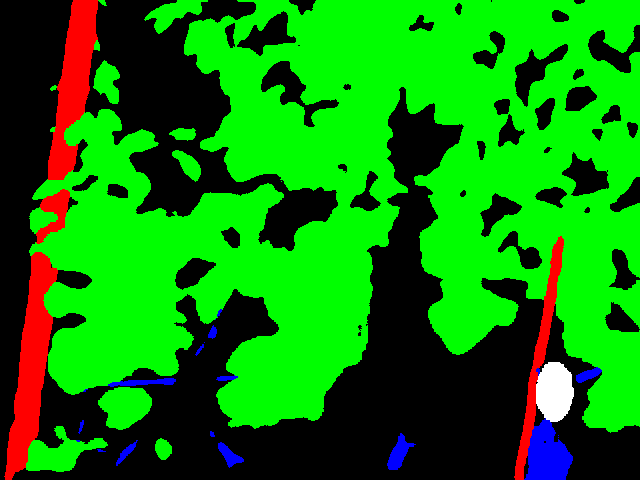

In [ ]:
mask